In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger
Example for the package
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
# General
config["general"]["random state seed"] = 10
# Scenario
config['scenario']['population size'] = 100
config['scenario']['duration'] = 60
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 5e-3
config['scenario']['injection']['y range'] = [7.5, 12.5]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "response": True,
    "type": "Flat",
    "mean detection prob": 0.5
}
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 100.
config['organisms']['photon yield'] = 1e6
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 20.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 35.,
    'y_length': 5.,
    "offset": np.array([0., 7.5]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.3,
    "x_pos": 5.,
    "y_pos": 10.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/cyclic/"
config['water']['model']['time step'] = 1
config['advanced']['starting step'] = 575

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

In [9]:
# from scipy.stats import gamma
# test_array=np.full((24,),10)
# gamma.pdf(test_array,a=3)

In [10]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,pulse mean,pulse sd,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Lampea sp.,25.518724,18.677068,0.0,0.538894,0.001422,1.0000,False,12.227495,0.1,0.0001,5.0,4.0,False,0.0,0.0,0.000000e+00,0.000000
1,Lampea sp.,14.958880,11.179783,0.0,0.000000,0.000958,0.9055,True,14.436380,0.1,0.0001,5.0,4.0,True,65.0,0.0,1.443638e+06,0.116573
2,Bathyctena chuni (Moser),0.097270,13.448982,0.0,1.577966,0.000992,1.0000,False,13.477492,0.1,0.0001,2.0,1.0,False,0.0,0.0,0.000000e+00,0.000000
3,Bathyctena chuni (Moser),21.953315,1.541073,0.0,2.101950,0.001236,1.0000,False,18.206609,0.1,0.0001,2.0,1.0,False,0.0,0.0,0.000000e+00,0.000000
4,Lampea sp.,5.079870,4.997716,0.0,5.105421,0.000858,1.0000,False,6.204426,0.1,0.0001,5.0,4.0,False,0.0,0.0,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Bathyctena chuni (Moser),10.446604,4.556822,0.0,5.610093,0.001222,1.0000,False,3.407697,0.1,0.0001,2.0,1.0,False,0.0,0.0,0.000000e+00,0.000000
96,Euphysora valdiviae Vanhoeffen,34.551629,4.758134,0.0,6.129114,0.001451,1.0000,False,9.896208,0.1,0.0001,20.0,15.0,False,0.0,0.0,0.000000e+00,0.000000
97,Lampea sp.,5.075972,4.903616,0.0,3.179994,0.001463,1.0000,False,4.029607,0.1,0.0001,5.0,4.0,False,0.0,0.0,0.000000e+00,0.000000
98,Lampea sp.,14.837056,13.251894,0.0,5.885001,0.000693,1.0000,False,18.319003,0.1,0.0001,5.0,4.0,False,0.0,0.0,0.000000e+00,0.000000


In [22]:
# Generated
generated = np.array([np.sum(fd.statistics[i].loc[:, 'photons'].values)
                      for i in range(len(fd.t))])
# Random noise
noise = np.abs(np.random.normal(2e2, 1e2, len(generated)))

In [23]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=1.5
h_length=1.5

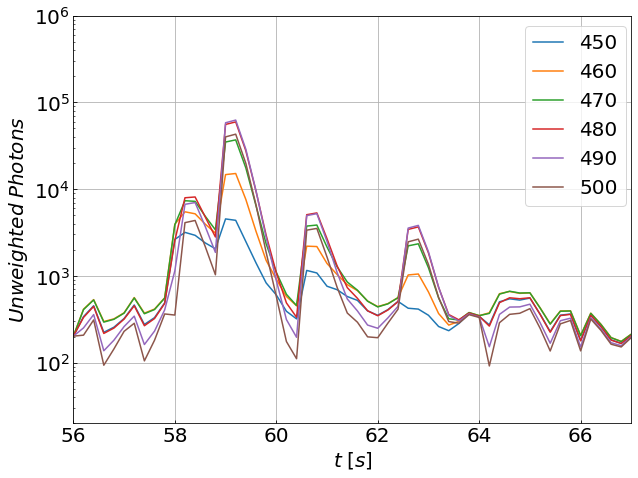

In [24]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ax1.plot(fd.t,
#          generated + noise,'r',
#          lw=lw, label=r'$Generated$')
# ax1.plot(fd.t,
#          fd.light_yields[:, :, 0].flatten() + noise,'b',
#          lw=lw, label=r'$Arriving$')
for i, _ in enumerate(fd.wavelengths):
    ax1.plot(fd.t / 5. + 56.,
             fd.measured[:, i] + noise,
             lw=lw, label='%.d' % fd.wavelengths[i])
#ax1.set_ylim(1e6, 1e11)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.9, +1.),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax1.set_xlim(56., 67.)
ax1.set_ylim(2e1,1e6)
plt.show()

In [14]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')

In [15]:
for i, _ in enumerate(fd.wavelengths):
    ax1.plot(fd.t,
             fd.measured[:, i] + noise,
             lw=lw)